# Train Notebook

This notebook contains the training pipeline of the detection model. It automatically saves model performance and creates an inference `csv` file on the test dataset.

Currently it has a very rudimentary implementation integrating the filter with the detection model and fine-tuning it. In the future this will be separated, as the detection network is a much too heavy head for the filter. Fine-tuning is also a challenge in this configuration, since the typical starting training learning rate for the filter is 1e-3 and for the detection model it is 1e-5. I tried training them separately while freezing the other with limited success.

This notebook is designed to run locally or on a Kaggle notebook instance. It can use CPU (really, really not recommended), GPU, or TPU acceleration.

### Data

The data in this model is of the shape [4096,3] for each sample. It contains three time series as channels of length 2 seconds sampled at 2048 Hz. Each of the channels represents the measured strain from each of the three detectors (LIGO Hanford, LIGO Livingston, Virgo). Each of these detectors has two perpendicular arms with length 4km for the LIGO detectors and 3km for the Virgo detector. The strain describes the relative change in length between the arms and is on the order of $\mathcal{O}(10^{-20})$ before low-pass filtering and $\mathcal{O}(10^{-21})$ after. This is also the approximate order of expected gravitational wave measurements. The data is in most cases dominated by noise.

## Setup

### Choose GPU

Detects whether the notebook is running on my workstation or on kaggle. Unfortunately the environment names on kaggle are randomly generated, as far as I can tell, so you will need to enter your own computer name, or just set `KAGGLE` to `False` if you intend on running the notebook locally.

In [1]:
import socket
import os

KAGGLE = True
if socket.gethostname() == "Computerfon":
    KAGGLE = False
print(f"KAGGLE: {KAGGLE}")
if not KAGGLE:
            # set available accelerator to keep tensorflow from intantiating on possible other GPUs
            os.environ["CUDA_VISIBLE_DEVICES"] = "0"


KAGGLE: False


### Imports

In [2]:
# general
import os
import gc
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

from glob import glob
import random
import numpy as np
import pandas as pd
import json
from IPython.core.display import display, HTML
if KAGGLE:
    from kaggle_datasets import KaggleDatasets

# ML
from sklearn.metrics import roc_auc_score

# DL
import tensorflow as tf
import tensorflow_addons as tfa
# tf.config.optimizer.set_jit(True)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Enable memory growth to get an idea of the size of the model
if not KAGGLE:
    physical_devices = tf.config.list_physical_devices("GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Static settings

#### !Eager Execution!

eager execution needs to be disabled if the model is meant for fine-tuning. This is due to a bug with the `keras` callback `modelCheckpoint`, which for some reason opens the `h5` file containing model information in `"w"` mode instead of `"r+"` which causes it to crash when training the second model, thus attempting to overwrite the file. This bug is not present when eager execution is disabled, although this will use significantly more memory, so is not advisable on the kaggle notebook. This bug can also be avoided by not using the callback on the second `keras.model.Model.fit()` call. Hopefully I will find a better solution in the future.

In [3]:
tf.compat.v1.disable_eager_execution()
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

### TPU Detection

In [4]:
def auto_select_accelerator():
    TPU_DETECTED = False
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        tf.keras.mixed_precision.set_global_policy("mixed_bfloat16")
        print(f"Running on TPU: {tpu.master()}")
        TPU_DETECTED = True
    except ValueError:
        strategy = tf.distribute.get_strategy()
        tf.keras.mixed_precision.set_global_policy("mixed_float16")
        
    num_replicas = strategy.num_replicas_in_sync
    print(f"Running on {num_replicas} replica{'s' if num_replicas > 1 else ''}")
    return strategy, TPU_DETECTED, num_replicas

## PARAMS

More static parameters, choose the folders in `../input/` you wish to train on. The notebook works with multiple datasets at the same time and will use the last ordered file in a folder as the validation file. This is important to keep in mind, when you create datasets you want to use for simultaneous training, the same samples need to be in the same files, or else you will have a data leak.

In [5]:
strategy, TPU_Detected, REPLICAS = auto_select_accelerator()
INPUT_DIR = "../input/g2net-gravitational-wave-detection"
MDLS_PATH = "." if KAGGLE else "../models"
# TRAIN_FILES_PATH = "../input/filtered*_tfrec"
AUTO = tf.data.experimental.AUTOTUNE
tfrec_folders = ["like-synthetic-short-whitened-highpassed-tfrec"]#, "like-synthetic-whitened-highpassed-"]#["whitened-longer-tfrec", "whitened-tfrec", "filtered-whitened-tfrec"]
if KAGGLE:
    tfrec_folders = ["filteredwhitenedtfrec","whitened-tfrec"]

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6
Running on 1 replica


Show results from previous models if available

In [6]:
# show results from previous models
results_df = "no file"
if not KAGGLE:
    results_df = pd.read_csv("../models/results.csv", index_col=[0]).tail(20)
results_df

,lr,version,train_mode,batch_size,epochs,bavg_epoch,bavg_loss,bavg_auc,changelog,seed
43,0.00001,200,full,256,100,36,0.464103,0.839057,1/4 lr,42.0
44,0.00100,210,full,256,100,24,0.444001,0.847384,1/4 lr,42.0
45,0.00010,221,full,256,100,40,0.435199,0.850387,1/4 lr,69.0
46,0.00010,222,full,256,100,26,0.437144,0.849532,1/4 lr,69.0
47,0.00010,224,full,256,100,30,0.434321,0.851999,Input layers: 1/2 kernel size. more kernels,69.0
48,0.00010,231,full,256,100,29,0.439757,0.848020,only whitened ds,69.0
49,0.00010,242,full,256,25,23,0.447073,0.848576,only whitened ds with sgd,42.0
50,0.00010,244,full,256,25,21,0.465401,0.834070,only whitened ds with sgd,42.0
51,0.00010,245,full,256,25,23,0.446809,0.842836,all ds,42.0
52,0.00010,247,full,256,35,9,0.444699,0.842759,second run with adam,42.0


Necessary when running on a Kaggle notebook using a TPU with a private dataset. In addition you need to attach your Google Cloud Services credentials to the notebook. This can be done by clicking on Add-ons -> Google Cloud SDK -> Attach to notebook in your Kaggle notebook.

In [7]:
if KAGGLE:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    user_credential = user_secrets.get_gcloud_credential()
    user_secrets.set_tensorflow_credential(user_credential)

#### The `Params` class

This class contains the important parameters of the model. You can add ones you think are important. They will be automatically be archived in both the model performance `csv` file found at `../models/results.csv` and in a separate `JSON` file in the model directory itself. Folds have not been implemented yet

In [8]:
if not os.path.exists(f"{MDLS_PATH}/results.csv"):
    VER = 1
else:
    results = pd.read_csv(f"{MDLS_PATH}/results.csv", index_col=[0])
    VER = int(results.version.max())
Params ={
    "lr": 1e-4 * REPLICAS,
    "version": VER,
    "train_mode": "full", #test, full
    "batch_size": 256 * REPLICAS,
    "epochs": 35,
    "seed": 1111,
    "changelog": "simple detection network with same pre-processing applied to synthetic training dataset as kaggle dataset",
}
seed_everything(Params["seed"])

Make Model directory

In [9]:
VER = Params["version"]
MDL_PATH = f"{MDLS_PATH}/models_v{VER:03}"
while os.path.exists(MDL_PATH):
    VER += 1
    MDL_PATH = f"{MDLS_PATH}/models_v{VER:03}"
Params["version"]=VER
os.mkdir(MDL_PATH)

## Convenience Functions

### Data Augmentation: random_cut():

This augmentation function works on whole batches of data, to reduce the computational expense. It should not impact performance in this way.

It is written in a way to work in all runtimes in which the notebook has been testest (kaggle, local) and (GPU, TPU).

The function randomly cuts off a random amount of data points from the beginning and the end of each sample and replaces them with zeros. This is done in 35% of cases. The reason for this is, that this produces models that are resistant to overfitting, but still work on un-augmented test data during inference. More than 35% produced models that no longer generalized well, giving the impression of training two separate models. The `maxVal` variable represents the maximum value of data points cut off from both the beginning and end of the tensor. This was successful up to 512 data points or 0.25 seconds. It is not advisable to cut off more, since the signal seems to be located at around 1.5s in most cases.

Independently moving the result in the output tensor, with the intent of making the models more translation invariant,  created models that no longer performed well when infering on un-augmented test data. However overfitting was reduced drastically even with more complex models. So using this together with test-time augmentation would be a good idea in the future.

The function then randomly changes the sign of each of the channels independently. It might also be a good idea to randomly multiply the model with a scaling factor of 0.9-1.0 until the model is used to estimate the parameters of the gravitational waves in the future (masses of the bodies, spin, etc.)

In [10]:
def random_cut(x,y):
    tensor = x
    if random.random() > 0.6:
        maxVal=256
        dt = tf.random.uniform(shape=[],minval=2, maxval=maxVal, dtype=tf.int32)
        t0 = tf.random.uniform(shape=[],minval=1, maxval=dt, dtype=tf.int32)
        t1 = tf.random.uniform(shape=[],minval=0, maxval=t0, dtype=tf.int32)
        paddings =  [
            [0,0],
            [t0,dt-t0], 
#             [t1, dt-t1],# if you want to move the resulting tensor randomly in the output tensor
            [0,0]
        ]
        tensor = tf.pad(tensor[:,t0:t0+(4096-dt)], paddings=paddings)
    tensor = tensor * [-1. if random.random() > 0.5 else 1.,
                       -1. if random.random() > 0.5 else 1.,
                       -1. if random.random() > 0.5 else 1.]
    # Necessary for TPU runtime
    tensor = tf.reshape(tensor,[Params["batch_size"], 4096, 3])
    # Necessary for GPU runtime
    tensor = tf.cast(tensor, tf.float32)
    return tensor, y

### load_dataset()
Loads the dataset from folders containing `tfrec` files. The train file names are expected to begin with "train" and the test files with "test".

A large shuffle buffer is recommended in a large, heterogenous dataset, i.e. if the data pre-processing is different in the datasets used. The Kaggle dataset is quite large with 560,000 train samples and 226,000 test samples. In that case pick a large shuffle buffer, that works with the available memory.

It is not recommended to add caching functionality when using the Kaggle dataset, as it will use inordinate amounts of RAM

In [11]:
def load_dataset(files, shuffle=True, ordered=False, labeled = True, repeat=True, return_labels = False, cut = False, cache=False):
    if ordered:
        dataset = tf.data.TFRecordDataset(files, num_parallel_reads=None)
    else:
        dataset = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    

    def _parse_function(example_proto):
        if labeled:
            keys_to_feature = {
                "TimeSeries":tf.io.FixedLenFeature([4096,3],tf.float32),
                "Target":tf.io.FixedLenFeature([], tf.int64, default_value=0)}
            if return_labels:
                keys_to_feature["id"]=tf.io.FixedLenFeature([],tf.string, default_value="")
        else:
            keys_to_feature = {
                "TimeSeries": tf.io.FixedLenFeature([4096,3],tf.float32)
            }
        parsed_features = tf.io.parse_single_example(example_proto, keys_to_feature)
        if labeled:
            if return_labels:
                return parsed_features["TimeSeries"], parsed_features["Target"], parsed_features["id"]
            else:
                return parsed_features["TimeSeries"], parsed_features["Target"]
        else:
            return parsed_features["TimeSeries"]
    if not ordered:
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic=False
        dataset = dataset.with_options(ignore_order)
    # parse the record into tensors.
    dataset = dataset.map(_parse_function, num_parallel_calls=AUTO)
#     dataset = dataset.cache()

    # Repeat the input infinitely
    if repeat:
        dataset = dataset.repeat()

    # shuffle the dataset
    if shuffle:
        dataset = dataset.shuffle(buffer_size=50000, reshuffle_each_iteration=True)




#     # Generate batches
    dataset = dataset.batch(Params["batch_size"])
    if cut:
        dataset = dataset.map(random_cut, num_parallel_calls=AUTO, deterministic=False)
    dataset = dataset.prefetch(AUTO)
    return dataset

### get_train_val_files()

This function splits the available `tfrec` datasets, which can be created using `makeDataset.py` into train and val files, while also creating a list of train files, that are in the right order, for deciding which version of the test files to infer on when submitting to the competition. This functionality has been changed to only include the val files later on, since models overfit to differing degrees on datasets with different pre-processing. It also returns a list of the test files, that are used for inference.

In [12]:
def get_train_val_files(folders):
    train_files = []
    val_files = []
    test_files = []
    all_train_files = []
    for folder in folders:
        if KAGGLE:
            TRAIN_FILES_PATH = KaggleDatasets().get_gcs_path(folder)
            TEST_FILES_PATH = KaggleDatasets().get_gcs_path(f"{folder}test")
            all_files_train = np.sort(tf.io.gfile.glob(f"{TRAIN_FILES_PATH}/train_*.tfrec"))
            all_files_test = np.sort(tf.io.gfile.glob(f"{TEST_FILES_PATH}/test_*.tfrec"))
        else:
            all_files_train = np.sort(glob(f"../input/{folder}/train*.tfrec"))
            all_files_test = np.sort(glob(f"../input/{folder}/test*.tfrec"))
        
        if Params["train_mode"] == "test":
            train_files.extend(all_files_train[:1])
            val_files.extend(all_files_train[-1:])
            
        else:
            train_files.extend(all_files_train[:-2])
            val_files.extend(all_files_train[-2:])
        test_files.append(all_files_test)
        all_train_files.append(all_files_train)
    return train_files, val_files, test_files, all_train_files

train_files, val_files, test_files, all_train_files = get_train_val_files(tfrec_folders)


create the Tensorflow datasets

In [13]:
train_ds = load_dataset(train_files, cut=True)
val_ds = load_dataset(val_files, shuffle=False, cache=False, ordered=True, repeat=True)
gc.collect()

4

In [14]:
steps_per_epoch = 560000 // 16 * len(train_files) // Params["batch_size"]
validation_steps = 560000 // 16 * len(val_files) // Params["batch_size"]

## Models

This is the best performing model architecture. It was originally based on the architecture described in [this paper](https://arxiv.org/abs/1908.03151) and [this paper](https://arxiv.org/abs/2012.13101), but altered for higher performance in low SNR situations. The model in this form has excessive complexity and it should be possible to slim it down without sacrificing too much performance. The main performance-boosting change was increasing the layer count in the second convolution block to 3 instead of the 1 proposed in the papers.

Altered version of the above model, that I'm currently testing

load a trained version of the filter, to use for fine-tuning. The current detection model is not suited well as a head for this filter, since it is far to complex for such a task

In [15]:
pre_filter = tf.keras.models.load_model("model5.h5")
pre_filter.trainable=False
pre_filter.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4096, 12)          156       
_________________________________________________________________
reshape (Reshape)            (None, 4096, 12, 1)       0         
_________________________________________________________________
time_distributed (TimeDistri (None, 4096, 12, 32)      128       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4096, 6, 32)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4096, 6, 16)       1552      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 4096, 96)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 4096, 256)         2

less complex model with filter for fine-tuning

In [16]:
from tensorflow.keras import Sequential, layers
with strategy.scope():
    model = Sequential([
        tf.keras.Input(shape=([4096,3])),
        pre_filter,
        layers.Conv1D(filters=64*3, activation=None, kernel_size=64, padding="causal",input_shape=[4096,3], groups=3),
        layers.BatchNormalization(),
        layers.Activation("elu"),
        
        layers.Conv1D(filters=64, activation=None, kernel_size=32, padding="causal"),
        layers.MaxPool1D(pool_size=8),
        layers.BatchNormalization(),
        layers.Activation("elu"),
        
        layers.Conv1D(filters=128, activation=None,kernel_size=32, padding="causal"),
        layers.BatchNormalization(),
        layers.Activation("elu"),
        
        layers.Conv1D(filters=128, activation=None,kernel_size=16, padding="causal"),
        layers.AvgPool1D(pool_size=6),
        layers.BatchNormalization(),
        layers.Activation("elu"),
        
        layers.Conv1D(filters=256, activation="relu",kernel_size=16, padding="causal"),
        layers.BatchNormalization(),
        layers.Activation("elu"),
        
        
        layers.Flatten(),
        layers.Dense(64, activation=None),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Activation("elu"),
        
        layers.Dense(64, activation=None),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Activation("elu"),
        
        
        layers.Dropout(0.4),
        layers.Dense(1, kernel_constraint=tf.keras.constraints.MinMaxNorm(min_value=0.001, max_value=0.999),
                     kernel_initializer=tf.keras.initializers.RandomUniform(minval=0.3, maxval=0.4)
                    ),
        layers.Activation("sigmoid", dtype="float32")
    ])
    
    lr_decayed_fn = tf.keras.experimental.CosineDecay(
        1e-3,
        steps_per_epoch
    )
    opt = tfa.optimizers.Lookahead(
        tfa.optimizers.AdamW(lr_decayed_fn, learning_rate = Params["lr"]),
        sync_period=6
    )

    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    AUC = tf.keras.metrics.AUC(from_logits=True)

    #opt = tfa.optimizers.AdamW(lr_decayed_fn, learning_rate = Params["lr"])
    model.compile(
        opt,
        loss=loss,
        metrics=[AUC]
    )
    model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 4096, 3)           1024559   
_________________________________________________________________
conv1d (Conv1D)              (None, 4096, 192)         12480     
_________________________________________________________________
batch_normalization (BatchNo (None, 4096, 192)         768       
_________________________________________________________________
activation (Activation)      (None, 4096, 192)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4096, 64)          393280    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 512, 64)           0         
__________________________________________________

### get_lr_callback()

This function creates a callback to alter the learning rate in a way that has been shown to be advantageous. This is an altered version of the one seen in [this notebook](https://www.kaggle.com/miklgr500/cqt-g2net-efficientnetb7-tpu-training-w-b#Build-Model).

In [17]:
def get_lr_callback(batch_size=8):
    lr_start = Params["lr"]
    lr_max = 0.0000015 * batch_size
    lr_min = 1e-7
    lr_ramp_ep = 3
    lr_sus_ep = 0
    lr_decay = 0.7
    
    def lrfn(epoch):
        initial_epochs = 4
        
        epoch = epoch - initial_epochs
        if epoch < -1 * initial_epochs + 2:
            return lr_start/10
        elif epoch < 0:
            lr = lr_start
        elif epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    return lr_callback

Text(0.5, 1.0, 'Learning Rate Schedule with batch size of 256')

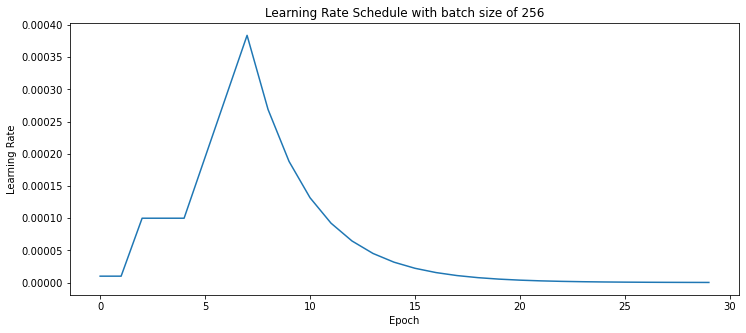

In [18]:
def lrfn(epoch):
    lr_start = Params["lr"]
    lr_max = 0.0000015 * Params["batch_size"]
    lr_min = 1e-7
    lr_ramp_ep = 3
    lr_sus_ep = 0
    lr_decay = 0.7
    initial_epochs = 4

    epoch = epoch - initial_epochs
    if epoch < -1 * initial_epochs + 2:
        return lr_start/10
    elif epoch < 0:
        lr = lr_start
    elif epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
    return lr

lrs = []
for epoch in range(30):
    lrs.append(lrfn(epoch))
    
plt.figure(figsize=(12,5))
plt.plot(lrs)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule with batch size of 256")

The model is trained at 1/10 of `Params["lr"]`, for which 1e-4 is recommended for the best performing architecture described above, since the models don't always converge when starting out at 1e-4. This was not used when training the model with the included filter.

### Callbacks

In [19]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2,
    patience=6, min_lr = 1e-7,
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta = 0.0003,
    mode="min",
    patience=10
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f"{MDL_PATH}/model_{Params['version']:03}.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weight_only=False,
    mode="min",
    save_freq="epoch",
    
)

callbacks=[get_lr_callback(Params["batch_size"]) ,reduce_lr, early_stop, model_checkpoint]
# callbacks=[reduce_lr, early_stop,model_checkpoint]


## Training

### Train Head

In [ ]:
history = model.fit(train_ds, validation_data = val_ds, epochs = Params["epochs"], shuffle=False,
                    steps_per_epoch = steps_per_epoch, validation_steps=validation_steps,
                    verbose=1, callbacks=callbacks)

Train on 1914 steps, validate on 273 steps

Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/35
1656/1914 [========================>.....] - ETA: 2:11 - batch: 827.5000 - size: 1.0000 - loss: 0.5828 - auc: 0.7427

### Train filter

Now training is enabled on the filter itself. The filter requires a much higher learning rate than the detection network, so the layers of the detection network are not trained until the filter converges. Once the filter converges, the whole network can be trained at the same time. The reason the filter needs to be trained at such a high learning rate instead of just fine-tuning it, is that the pre-processing of the currently finished synthetic datasets used to train the filter is unfortunately different to the pre-processing applied to the Kaggle dataset:

* in the synthetic dataset, the signal was whitened and bandpassed over a signal length of 8s, then cut down to 2s. This means the data corruption of the filtering process was cut out of the signal. Due to the fact that in the Kaggle dataset only 2s of time is available for each sample, the filters were applied to that time-frame, letting the data corruption caused by the filters influence the whole time series.

* additionally the parameters of the filters were different on both datasets. The whitening process, for example used a window length of 4s on the synthetic dataset, whereas a 0.5s window was used on the Kaggle dataset.

* The reported signal to noise ratio(SNR) of the tool used to create the synthetic datasets is either incorrect or the SNR of the Kaggle dataset is very low. This can be seen because detection models without filter, which were only trained on the pre-processed Kaggle dataset perform very highly on the synthetic datasets (up to a area under curve (AUC) score of 0.95, compared to 0.85 on the datasets used for training), which have never been seen by the model. This implies that either for reasons of SNR inconsistencies or because of data corruption by the filters, the Kaggle dataset is much harder than the synthetic ones, which makes the filter not well-posed on the Kaggle dataset, which necessitates a reasonably high learning rate. Additionally the learning rate required by the filter is in general 2 orders of magnitude higher than that of the detection network. In general the tool used to create the synthetic datasets reports a SNR of around 6 which is very low and should not lead to such high AUC scores. Additionally the way the signals are treated by the tool should lead to a consistent SNR at any simulated distance between detector and event, but in practice the pre-trained detection models perform worse on datasets with a higher distance and the same reported SNR.

To alleviate these issues new synthetic datasets are currently being created without any pre-processing and at different distances to be able to apply the same pre-processing pipeline to the samples as is used on the Kaggle datasets, so that the filter can be trained on a comparable dataset to the Kaggle one, hopefully leading to a better posed filter.

The reason for creating synthetic datasets for training the filter is that the Kaggle dataset only has a binary target, either there is a gravitational wave in the noise or not. To be able to train a filter to recreate the wavelet pattern, the shape of the wavelet hast to be known.

#### Enable Training on Filter

only the layers of the encoder are trained here. This is done, because the goal is to get the encoder to encode the same way it did on the synthetic training datasets and also because the LSTM layers of the decoder part of the filter take a lot of training time, especially on a TPU runtime, where the CUDA implementation does not work and necessitates the use of the CPU.

### Fine-tuning

After the filter converges with the pre-trained Detection model, the complete model can now be trained at a lower learning rate, although at the time of writing the detection model is still much to complex, making overfitting a significant problem.

In [ ]:
with strategy.scope():
    pre_filter.trainable=False
    for layer in model.layers:
        layer.trainable=True
    for layer in pre_filter.layers:
        layer.trainable=True
    
#     for i,layer in enumerate(pre_filter.layers[6:]):
#         print(i, layer)
#         layer.trainable=False

    opt = tfa.optimizers.Lookahead(
#         tfa.optimizers.AdamW(lr_decayed_fn, learning_rate = 1e-4),
        tf.keras.optimizers.Adam(learning_rate=5e-6),
        sync_period=6
    )
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    AUC = tf.keras.metrics.AUC()


    model.compile(
        opt,
        loss=loss,
        metrics=[AUC]
    )
    model.summary()
    # model is loaded from checkpoint to get the best performing model
    # hopefully alleviating some overfitting
#     model.load_weights(f"{MDL_PATH}/model_{Params['version']:03}.h5".replace(f"{VER:03}","446"))
    

In [ ]:
# tf.keras.backend.clear_session()

In [ ]:
history2 = model.fit(train_ds, validation_data = val_ds, epochs = Params["epochs"], shuffle=True,
                    steps_per_epoch = steps_per_epoch, validation_steps=validation_steps,
                    verbose=1, callbacks=callbacks)

## Analysis

### Log model performance

In [ ]:
historyFrame = pd.DataFrame(history.history)
historyFrame[["auc", "val_auc"]].plot()
historyFrame[["loss", "val_loss"]].plot()
historyFrame.to_csv(f"{MDL_PATH}/history_mdl{Params['version']:03}.csv", index=False)

In [ ]:
historyFrame2 = pd.DataFrame(history2.history)
historyFrame2[["auc_1", "val_auc_1"]].plot()
historyFrame2[["loss", "val_loss"]].plot()
historyFrame2.to_csv(f"{MDL_PATH}/history_mdl{Params['version']:03}.csv", index=False)

In [ ]:
historyFrame

In [ ]:
best_epoch = historyFrame.val_auc.argmax()
best_loss = historyFrame.iloc[best_epoch].loss
best_auc = historyFrame.iloc[best_epoch].val_auc
print("best epoch:", best_epoch,
      "| best loss:", best_loss,
      "| best auc:", best_auc
     )

In [ ]:
best_epoch = historyFrame2.val_auc_1.argmax()
best_loss = historyFrame2.iloc[best_epoch].loss
best_auc = historyFrame2.iloc[best_epoch].val_auc_1
print("best epoch:", best_epoch,
      "| best loss:", best_loss,
      "| best auc:", best_auc
     )

In [ ]:
result = Params.copy()
result["bavg_epoch"] = int(best_epoch)
result["bavg_loss"] = float(best_loss)
result["bavg_auc"] = float(best_auc)
with open(f"{MDL_PATH}/params.json", "w") as file:
    json.dump(result, file)

if not os.path.exists(f"{MDLS_PATH}/results.csv"):
    df_save = pd.DataFrame(result, index=[0])
    df_save.to_csv(f"{MDLS_PATH}/results.csv")
else:
    df_old = pd.read_csv(f"{MDLS_PATH}/results.csv", index_col=0)
    df_save = pd.DataFrame(result, index = [df_old.index.max() + 1])
    df_save = df_old.append(df_save, ignore_index=True)
    df_save.to_csv(f"{MDLS_PATH}/results.csv")   

In [ ]:
pd.read_csv(f"{MDLS_PATH}/results.csv",index_col=[0])

In [ ]:
del train_ds, val_ds
gc.collect()

### Inference on Test Data

In [ ]:
prediction_scores = []
with strategy.scope():
    model2 = tf.keras.models.load_model(f"{MDL_PATH}/model_{Params['version']:03}.h5")
n_vals = len(val_files) // len(tfrec_folders)
for i in range(len(tfrec_folders)):
    files = val_files[i * n_vals: (i + 1)*n_vals] 
    val_ds = load_dataset(files, shuffle=False, cache=False, ordered=True, repeat=False)
    history = model.evaluate(val_ds, steps = 35000 * n_vals // Params["batch_size"])
    prediction_scores.append(history[1])
print(prediction_scores)
best_pred = np.array(prediction_scores).argmax()

In [ ]:
test_set = load_dataset(test_files[best_pred], cache=False, shuffle=False, ordered=True, labeled=False, repeat=False, return_labels=False)
test_prediction = model.predict(test_set)
sub = pd.read_csv("../input/g2net-gravitational-wave-detection/sample_submission.csv")
sub.target = test_prediction.flatten()
sub.to_csv(f"{MDL_PATH}/submission.csv", index=False)